<a href="https://colab.research.google.com/github/juanpaa97/data-jp/blob/main/Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Celda 0: Instalación de librerías
# Apretá el botón de "Play" a la izquierda de esta celda para ejecutarla.
!pip install pandas numpy statsmodels scikit-learn tqdm prophet

print("¡Librerías listas!")

¡Librerías listas!


In [2]:
# Celda 1: Carga de librerías y datos

# 1. Importar las herramientas que usaremos
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm  # Usamos la versión para notebooks
from google.colab import files
import warnings

warnings.filterwarnings('ignore') # Para ignorar advertencias y mantener la salida limpia

# 2. Subir los archivos a Colab
print("Por favor, sube tu archivo 'Inputs - data_demanda.csv'")
uploaded = files.upload()
DEMAND_FILE = list(uploaded.keys())[0]

print("\nPor favor, sube tu archivo 'Inputs - segmentacion.csv'")
uploaded = files.upload()
SEGMENTATION_FILE = list(uploaded.keys())[0]


# 3. Cargar los archivos en tablas (DataFrames) y limpiar los datos
df_demand = pd.read_csv(DEMAND_FILE)
df_segmentation = pd.read_csv(SEGMENTATION_FILE)

# Limpieza básica: convertir la columna de fecha a formato fecha y las de números a formato numérico.
df_demand['PERIOD'] = pd.to_datetime(df_demand['PERIOD'])
for col in ['GMV', 'GMV_ADJ', 'ASP', 'ASP_AVG', 'GMV_BASELINE', 'SI_BASELINE', 'ELASTICITY_ADJ', 'SI', 'SI_ADJ']:
    if df_demand[col].dtype == 'object':
        df_demand[col] = pd.to_numeric(df_demand[col].str.replace(',', '').replace('[\$,]', '', regex=True), errors='coerce')

df_demand.dropna(subset=['SI_ADJ', 'SI_BASELINE', 'ASP', 'ASP_AVG', 'ELASTICITY_ADJ'], inplace=True)


print("\n¡Datos cargados y listos para usar!")
print("Última fecha en los datos:", df_demand['PERIOD'].max().strftime('%Y-%m-%d'))

Por favor, sube tu archivo 'Inputs - data_demanda.csv'


Saving Inputs - data_demanda.csv to Inputs - data_demanda.csv

Por favor, sube tu archivo 'Inputs - segmentacion.csv'


Saving Inputs - segmentacion.csv to Inputs - segmentacion.csv

¡Datos cargados y listos para usar!
Última fecha en los datos: 2025-07-01


In [57]:
# Celda 2 (v16 - Definitiva): El Modelo Final

import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

# --- MODELO UNIFICADO Y ROBUSTO PARA SEGMENTOS A y B (BASADO EN HOLT) ---
def forecast_unified_model(sku_history: pd.DataFrame, forecast_horizon: int, future_prices: list = None):
    # 1. FORECAST DE LA LÍNEA BASE (SI_BASELINE)
    ts_si_baseline = sku_history.set_index('PERIOD')['SI_BASELINE'].asfreq('MS')
    if len(ts_si_baseline) < 2:
        last_value = ts_si_baseline.iloc[-1] if not ts_si_baseline.empty else 0
        last_date = ts_si_baseline.index[-1] if not ts_si_baseline.empty else pd.to_datetime('today')
        future_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='MS')[1:]
        output_df = pd.DataFrame({'si_por_tendencia': [last_value] * forecast_horizon,'si_ajuste_precios': 0,'forecast_total': [last_value] * forecast_horizon, 'forecast_asp': sku_history['ASP'].iloc[-1] if not sku_history.empty else 0}, index=future_dates)
        fitted_df = pd.DataFrame(columns=['si_por_tendencia', 'si_ajuste_precios', 'forecast_total'])
        return output_df.clip(lower=0).round(), fitted_df

    model_base = ExponentialSmoothing(ts_si_baseline, trend='add', seasonal=None, initialization_method='estimated').fit()
    fcst_si_baseline = model_base.forecast(forecast_horizon)
    fitted_baseline = model_base.fittedvalues

    # 2. OBTENER PRECIOS FUTUROS (ASP)
    asp_forecast_values = []
    if future_prices is None:
        ts_asp = sku_history.set_index('PERIOD')['ASP'].asfreq('MS')
        last_date = ts_asp.index[-1]
        future_dates_for_price = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='MS')[1:]
        for date in future_dates_for_price:
            last_year_date = date - pd.DateOffset(years=1)
            try:
                sn_value = ts_asp[ts_asp.index.to_period('M') == last_year_date.to_period('M')].values[0]
                asp_forecast_values.append(sn_value)
            except IndexError:
                asp_forecast_values.append(ts_asp.iloc[-1])
    else:
        asp_forecast_values = future_prices

    # 3. CÁLCULO DEL AJUSTE PROMOCIONAL
    stable_elasticity = sku_history['ELASTICITY_ADJ'].mean(); stable_asp_avg = sku_history['ASP_AVG'].mean()
    if pd.isna(stable_elasticity) or pd.isna(stable_asp_avg) or stable_asp_avg == 0:
        future_adjustment_values = np.zeros(forecast_horizon)
    else:
        promo_adjustment_factor = (1 + stable_elasticity * ((pd.Series(asp_forecast_values) / stable_asp_avg) - 1))
        future_adjustment_values = (fcst_si_baseline.values * promo_adjustment_factor.values) - fcst_si_baseline.values
        future_adjustment_values = np.nan_to_num(future_adjustment_values, nan=0)

    # 4. COMBINACIÓN Y ESTRUCTURA DE SALIDA
    future_final_forecast_values = fcst_si_baseline.values + future_adjustment_values
    last_date = sku_history['PERIOD'].max()
    future_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='MS')[1:]
    output_df = pd.DataFrame({'si_por_tendencia': fcst_si_baseline.values,'si_ajuste_precios': future_adjustment_values,'forecast_total': future_final_forecast_values, 'forecast_asp': asp_forecast_values}, index=future_dates)
    ts_asp_historic = sku_history.set_index('PERIOD')['ASP'].asfreq('MS'); historic_promo_factor = (1 + stable_elasticity * ((ts_asp_historic / stable_asp_avg) - 1)); historic_promo_factor.fillna(1, inplace=True); historic_adjustment = (fitted_baseline.values * historic_promo_factor.values) - fitted_baseline.values; historic_total_forecast = fitted_baseline.values + historic_adjustment; fitted_df = pd.DataFrame({'si_por_tendencia': fitted_baseline.values, 'si_ajuste_precios': historic_adjustment, 'forecast_total': historic_total_forecast }, index=fitted_baseline.index)
    output_df['forecast_total'] = output_df['forecast_total'].clip(lower=0); fitted_df['forecast_total'] = fitted_df['forecast_total'].clip(lower=0)
    return output_df.round(), fitted_df.round()

# --- MODELO SEGMENTO C (CORREGIDO Y ROBUSTO) ---
def forecast_segment_C(sku_history: pd.DataFrame, forecast_horizon: int):
    # Preparamos AMBAS series de tiempo (SI y ASP) con la misma base para consistencia
    ts_si_adj = sku_history.set_index('PERIOD')['SI_ADJ'].asfreq('MS')
    ts_asp = sku_history.set_index('PERIOD')['ASP'].asfreq('MS')

    forecast = []; asp_forecast = []

    if ts_si_adj.empty: # Red de seguridad si no hay historia
        last_date = pd.to_datetime('today')
        future_dates = pd.date_range(start=last_date, periods=forecast_horizon, freq='MS')
        forecast = [0] * forecast_horizon
        asp_forecast = [0] * forecast_horizon
    else:
        last_date = ts_si_adj.index[-1]
        future_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='MS')[1:]
        for date in future_dates:
            last_year_date = date - pd.DateOffset(years=1)
            try:
                # Buscar SI y ASP en la misma fecha del año anterior
                sn_value = ts_si_adj.loc[last_year_date]
                asp_value = ts_asp.loc[last_year_date]
                forecast.append(sn_value)
                asp_forecast.append(asp_value)
            except KeyError:
                # Fallback si no hay datos del año anterior
                fallback_si = ts_si_adj.tail(3).mean()
                fallback_asp = ts_asp.tail(3).mean()
                forecast.append(fallback_si if not pd.isna(fallback_si) else 0)
                asp_forecast.append(fallback_asp if not pd.isna(fallback_asp) else ts_asp.iloc[-1] if not ts_asp.empty else 0)

    output_df = pd.DataFrame({'si_por_tendencia': forecast, 'si_ajuste_precios': 0, 'forecast_total': forecast, 'forecast_asp': asp_forecast}, index=future_dates)
    fitted_df = pd.DataFrame(columns=['si_por_tendencia', 'si_ajuste_precios', 'forecast_total'])
    return output_df.clip(lower=0).round(), fitted_df

# --- FUNCIONES DE "ORQUESTACIÓN" ---
def forecast_segment_A(sku_history: pd.DataFrame, forecast_horizon: int, future_prices: list = None): return forecast_unified_model(sku_history, forecast_horizon, future_prices)
def forecast_segment_B(sku_history: pd.DataFrame, forecast_horizon: int, future_prices: list = None): return forecast_unified_model(sku_history, forecast_horizon, future_prices)
print("Modelo Definitivo cargado, con corrección de robustez para Segmento C.")

Modelo Definitivo cargado, con corrección de robustez para Segmento C.


--- ANÁLISIS DE SEGMENTO A (Simulación desde Dic-2024) ---
Analizando los 55 SKUs del Segmento A...


Generando forecasts para Segmento A:   0%|          | 0/55 [00:00<?, ?it/s]


--- ANÁLISIS DE RESULTADOS M+1 (ENERO 2025) ---
            Real  Tendencia  Efecto Promo  Forecast Total  ASP Real (Usado)  ASP Avg  % Dif ASP vs AVG  Elasticidad  Diferencia Abs.  APE (%)
SKU_ID                                                                                                                                       
DESK-3       741      645.0           3.0           648.0            827.57    834.0             -0.77        -0.62             93.0    12.55
DESK-4      1017      254.0           5.0           259.0           1032.19   1062.0             -2.81        -0.70            758.0    74.53
SILL-Q2G     144      233.0         -23.0           210.0           1380.25   1157.0             19.30        -0.51             66.0    45.83
ALOE          29      213.0           4.0           217.0           1868.23   1890.0             -1.15        -1.53            188.0   648.28
SILL2        135       11.0          -1.0            10.0           1204.93   1053.0             14

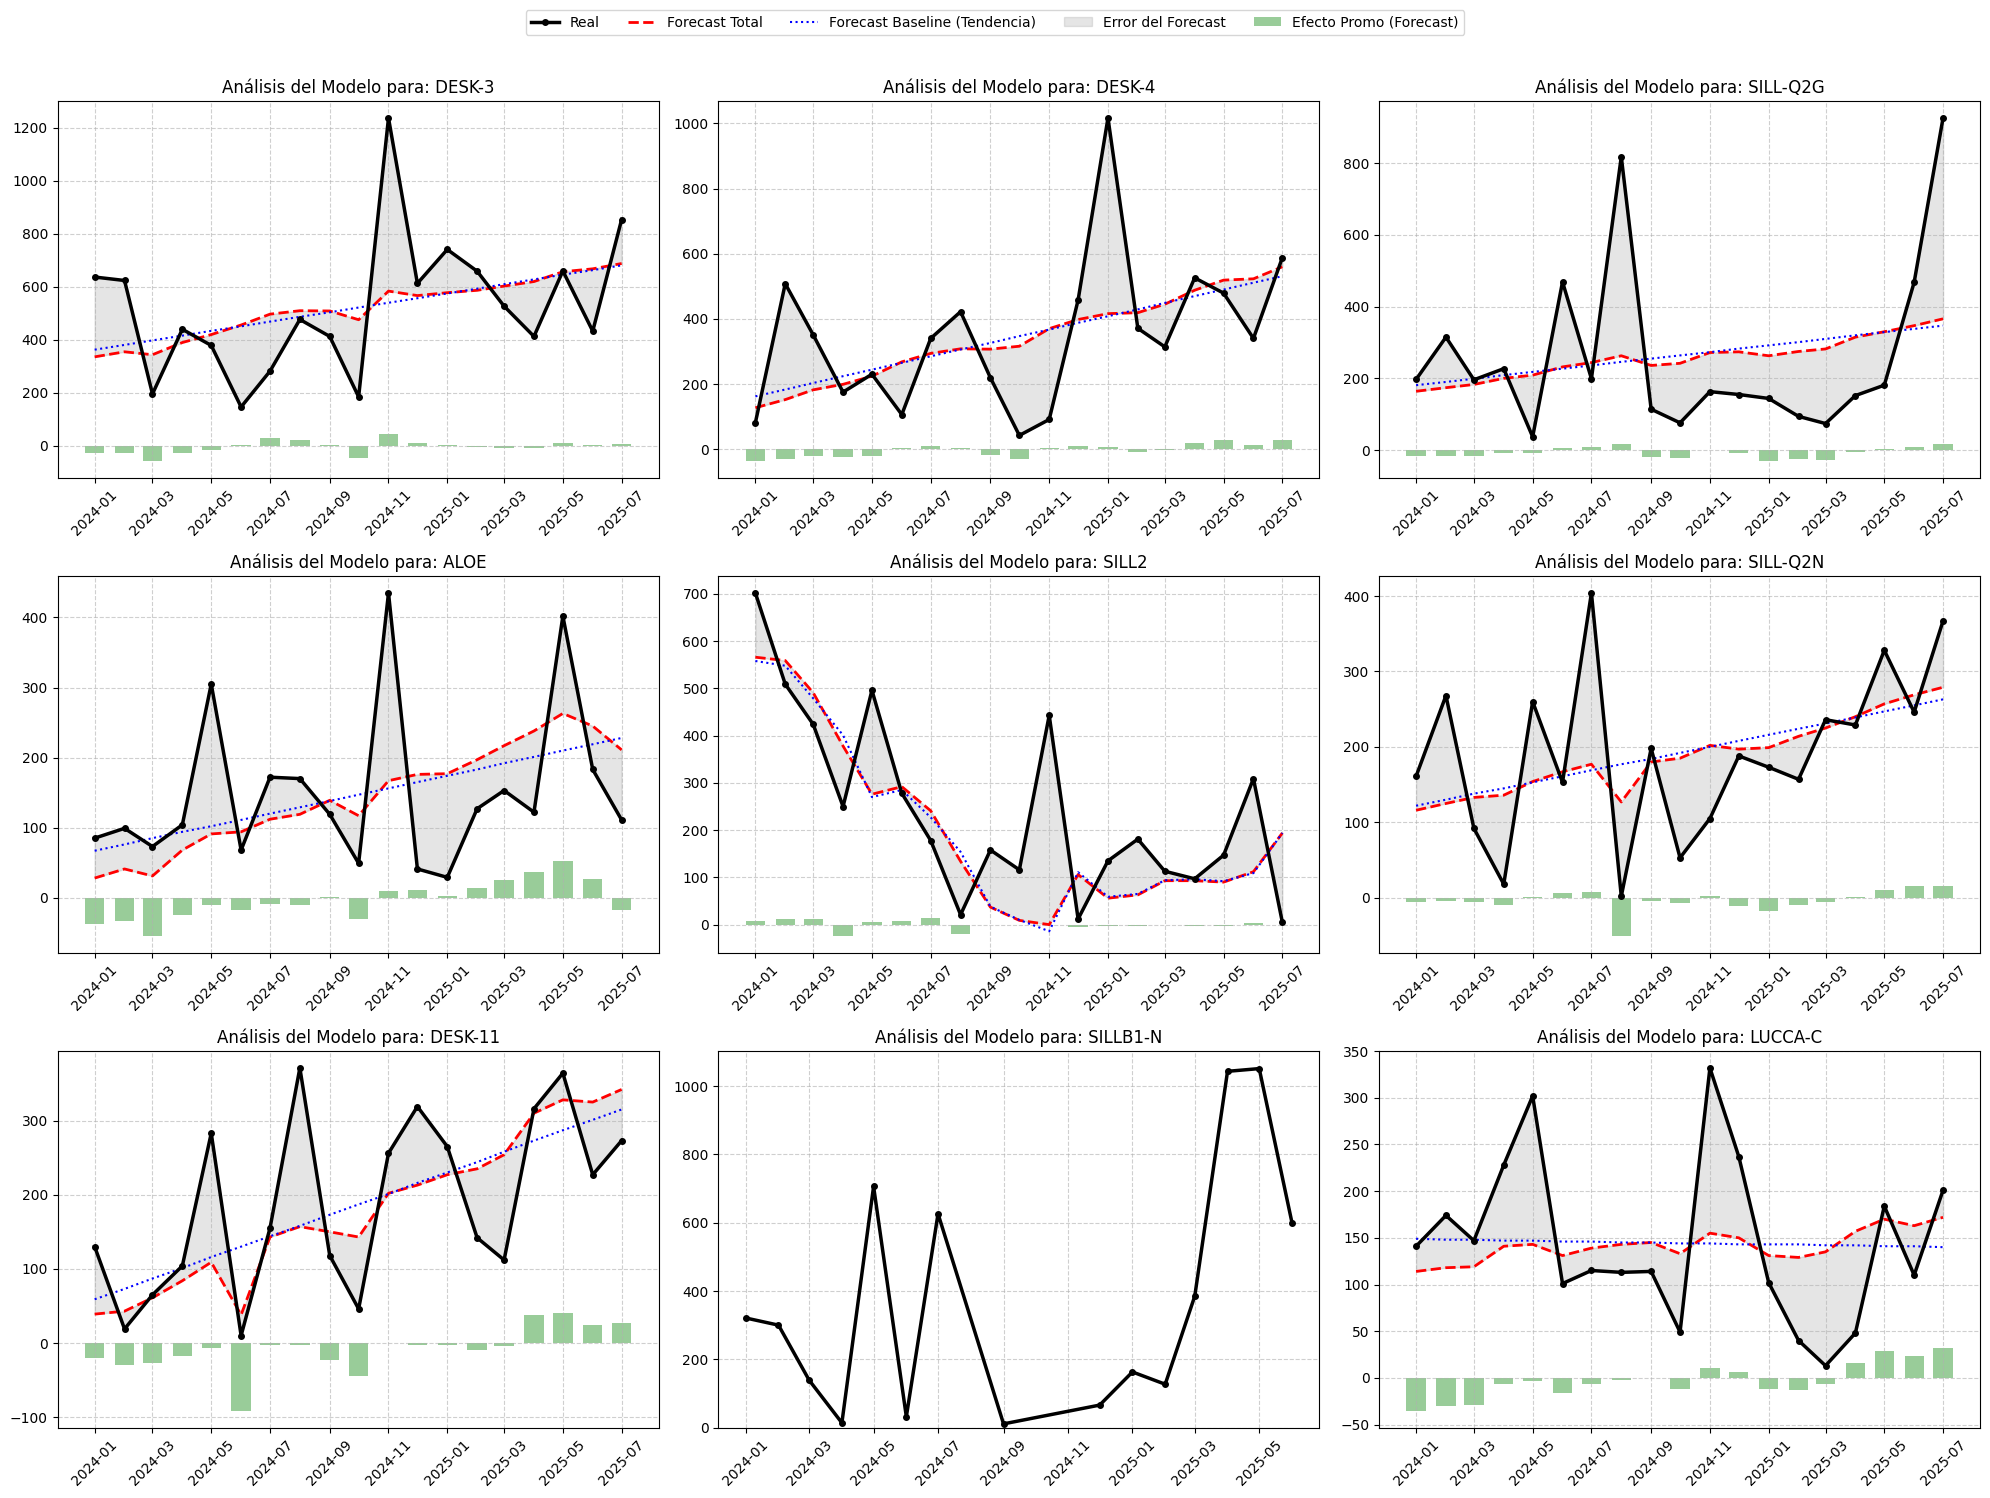

In [50]:
# Celda 3 (Final-Final): Análisis Completo del Segmento A

print("--- ANÁLISIS DE SEGMENTO A (Simulación desde Dic-2024) ---")
# ... (El código de la tabla de backtesting no cambia, se mantiene como en la versión anterior)
skus_segmento_A = df_segmentation[df_segmentation['ABC_SEG'] == 'A']['SKU_ID'].tolist()
print(f"Analizando los {len(skus_segmento_A)} SKUs del Segmento A...")
forecast_origin_date = pd.to_datetime('2024-12-31')
results_list = []
for sku_id in tqdm(skus_segmento_A, desc="Generando forecasts para Segmento A"):
    train_data = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] <= forecast_origin_date)]
    if len(train_data) < 2: continue
    date_m1 = pd.to_datetime('2025-01-01'); date_m4 = pd.to_datetime('2025-04-01')
    real_m1_row = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] == date_m1)]
    real_m4_row = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] == date_m4)]
    if real_m1_row.empty or real_m4_row.empty: continue
    asp_real_m1 = real_m1_row['ASP'].iloc[0]; real_m1 = real_m1_row['SI_ADJ'].iloc[0]
    asp_real_m4 = real_m4_row['ASP'].iloc[0]; real_m4 = real_m4_row['SI_ADJ'].iloc[0]
    stable_elasticity = train_data['ELASTICITY_ADJ'].mean(); stable_asp_avg = train_data['ASP_AVG'].mean()
    forecast_df, _ = forecast_segment_A(train_data, forecast_horizon=4, future_prices=[asp_real_m1, 0, 0, asp_real_m4])
    forecast_m1 = forecast_df.iloc[0]; forecast_m4 = forecast_df.iloc[3]
    results_list.append({'SKU_ID': sku_id, 'Horizonte': 'M+1', 'Real': real_m1,'Tendencia': forecast_m1['si_por_tendencia'],'Efecto Promo': forecast_m1['si_ajuste_precios'],'Forecast Total': forecast_m1['si_por_tendencia'] + forecast_m1['si_ajuste_precios'],'ASP Real (Usado)': asp_real_m1, 'ASP Avg': stable_asp_avg,'% Dif ASP vs AVG': (asp_real_m1 / stable_asp_avg - 1) * 100 if stable_asp_avg > 0 else 0,'Elasticidad': stable_elasticity})
    results_list.append({'SKU_ID': sku_id, 'Horizonte': 'M+4', 'Real': real_m4,'Tendencia': forecast_m4['si_por_tendencia'],'Efecto Promo': forecast_m4['si_ajuste_precios'],'Forecast Total': forecast_m4['si_por_tendencia'] + forecast_m4['si_ajuste_precios'],'ASP Real (Usado)': asp_real_m4, 'ASP Avg': stable_asp_avg,'% Dif ASP vs AVG': (asp_real_m4 / stable_asp_avg - 1) * 100 if stable_asp_avg > 0 else 0,'Elasticidad': stable_elasticity})
if results_list:
    results_df = pd.DataFrame(results_list); results_df['Diferencia Abs.'] = abs(results_df['Real'] - results_df['Forecast Total']); results_df['APE (%)'] = results_df['Diferencia Abs.'] / results_df['Real'] * 100; results_df.replace([np.inf, -np.inf], 0, inplace=True)
    m1_df = results_df[results_df['Horizonte'] == 'M+1'].set_index('SKU_ID').drop(columns='Horizonte'); m4_df = results_df[results_df['Horizonte'] == 'M+4'].set_index('SKU_ID').drop(columns='Horizonte')
    print("\n" + "="*70 + "\n--- ANÁLISIS DE RESULTADOS M+1 (ENERO 2025) ---\n" + "="*70); print(m1_df.round(2))
    print("\n" + "="*70 + "\n--- ANÁLISIS DE RESULTADOS M+4 (ABRIL 2025) ---\n" + "="*70); print(m4_df.round(2))
    wape_m1 = (m1_df['Diferencia Abs.'].sum() / m1_df['Real'].sum()) * 100; mape_m1 = m1_df['APE (%)'].mean()
    wape_m4 = (m4_df['Diferencia Abs.'].sum() / m4_df['Real'].sum()) * 100; mape_m4 = m4_df['APE (%)'].mean()
    print("\n--- MÉTRICAS CONSOLIDADAS DEL SEGMENTO A ---"); print(f"Accuracy Ponderado M+1: {100-wape_m1:.2f}% | MAPE M+1: {mape_m1:.2f}%"); print(f"Accuracy Ponderado M+4: {100-wape_m4:.2f}% | MAPE M+4: {mape_m4:.2f}%")

    # --- SECCIÓN DE GRÁFICOS (ACTUALIZADA) ---
    print("\n" + "="*50 + "\n--- ANÁLISIS GRÁFICO DE TOP 9 SKUs ---\n" + "="*50)
    top_9_skus = df_segmentation[df_segmentation['ABC_SEG'] == 'A']['SKU_ID'].head(9).tolist()
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()

    for i, sku in enumerate(top_9_skus):
        ax = axes[i]
        full_history = df_demand[df_demand['SKU_ID'] == sku]
        if full_history.empty:
            ax.text(0.5, 0.5, f'{sku}\n(Sin Datos)', ha='center', va='center'); ax.set_xticks([]); ax.set_yticks([])
            continue

        # Generamos el forecast y, más importante, el ajuste histórico (fitted)
        _, fitted_model_df = forecast_segment_A(full_history, forecast_horizon=1)

        plot_df = full_history.set_index('PERIOD')[['SI_ADJ']]
        plot_df = plot_df.join(fitted_model_df)

        # Graficar las curvas
        ax.plot(plot_df.index, plot_df['SI_ADJ'], label='Real', color='black', linewidth=2.5, marker='o', markersize=4, zorder=10)
        ax.plot(plot_df.index, plot_df['forecast_total'], label='Forecast Total', color='red', linestyle='--', linewidth=2)
        ax.plot(plot_df.index, plot_df['si_por_tendencia'], label='Forecast Baseline (Tendencia)', color='blue', linestyle=':')

        # Graficar el efecto promo del forecast como barras
        ax.bar(plot_df.index, plot_df['si_ajuste_precios'], label='Efecto Promo (Forecast)', color='green', alpha=0.4, width=20)

        # Sombrear el área de error
        ax.fill_between(plot_df.index, plot_df['SI_ADJ'], plot_df['forecast_total'], color='grey', alpha=0.2, label='Error del Forecast')

        ax.set_title(f'Análisis del Modelo para: {sku}', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='x', rotation=45)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    handles, labels = ax.get_legend_handles_labels()
    # Para evitar etiquetas duplicadas en la leyenda
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.0))
    plt.show()
else:
    print("\nNo se pudieron generar resultados para el Segmento A.")

--- ANÁLISIS DE SEGMENTO B (Simulación desde Dic-2024) ---
Analizando los 60 SKUs del Segmento B...


Generando forecasts para Segmento B:   0%|          | 0/60 [00:00<?, ?it/s]


--- ANÁLISIS DE RESULTADOS M+1 (ENERO 2025) ---
                  Real  Tendencia  Efecto Promo  Forecast Total  ASP Real (Usado)  ASP Avg  % Dif ASP vs AVG  Elasticidad  Diferencia Abs.  APE (%)
SKU_ID                                                                                                                                             
MOON                18        NaN           0.0             NaN            860.11    832.0              3.38        -0.18              NaN      NaN
TOKIO               11        NaN           0.0             NaN           1348.09   1181.0             14.15        -0.21              NaN      NaN
MOON-N              34       23.0          -1.0            22.0            870.09    792.0              9.86        -0.25             12.0    35.29
DINKA-CIELO         16        NaN           0.0             NaN           4999.00   4729.0              5.71        -0.17              NaN      NaN
TORONTO             41       13.0           0.0            13.0

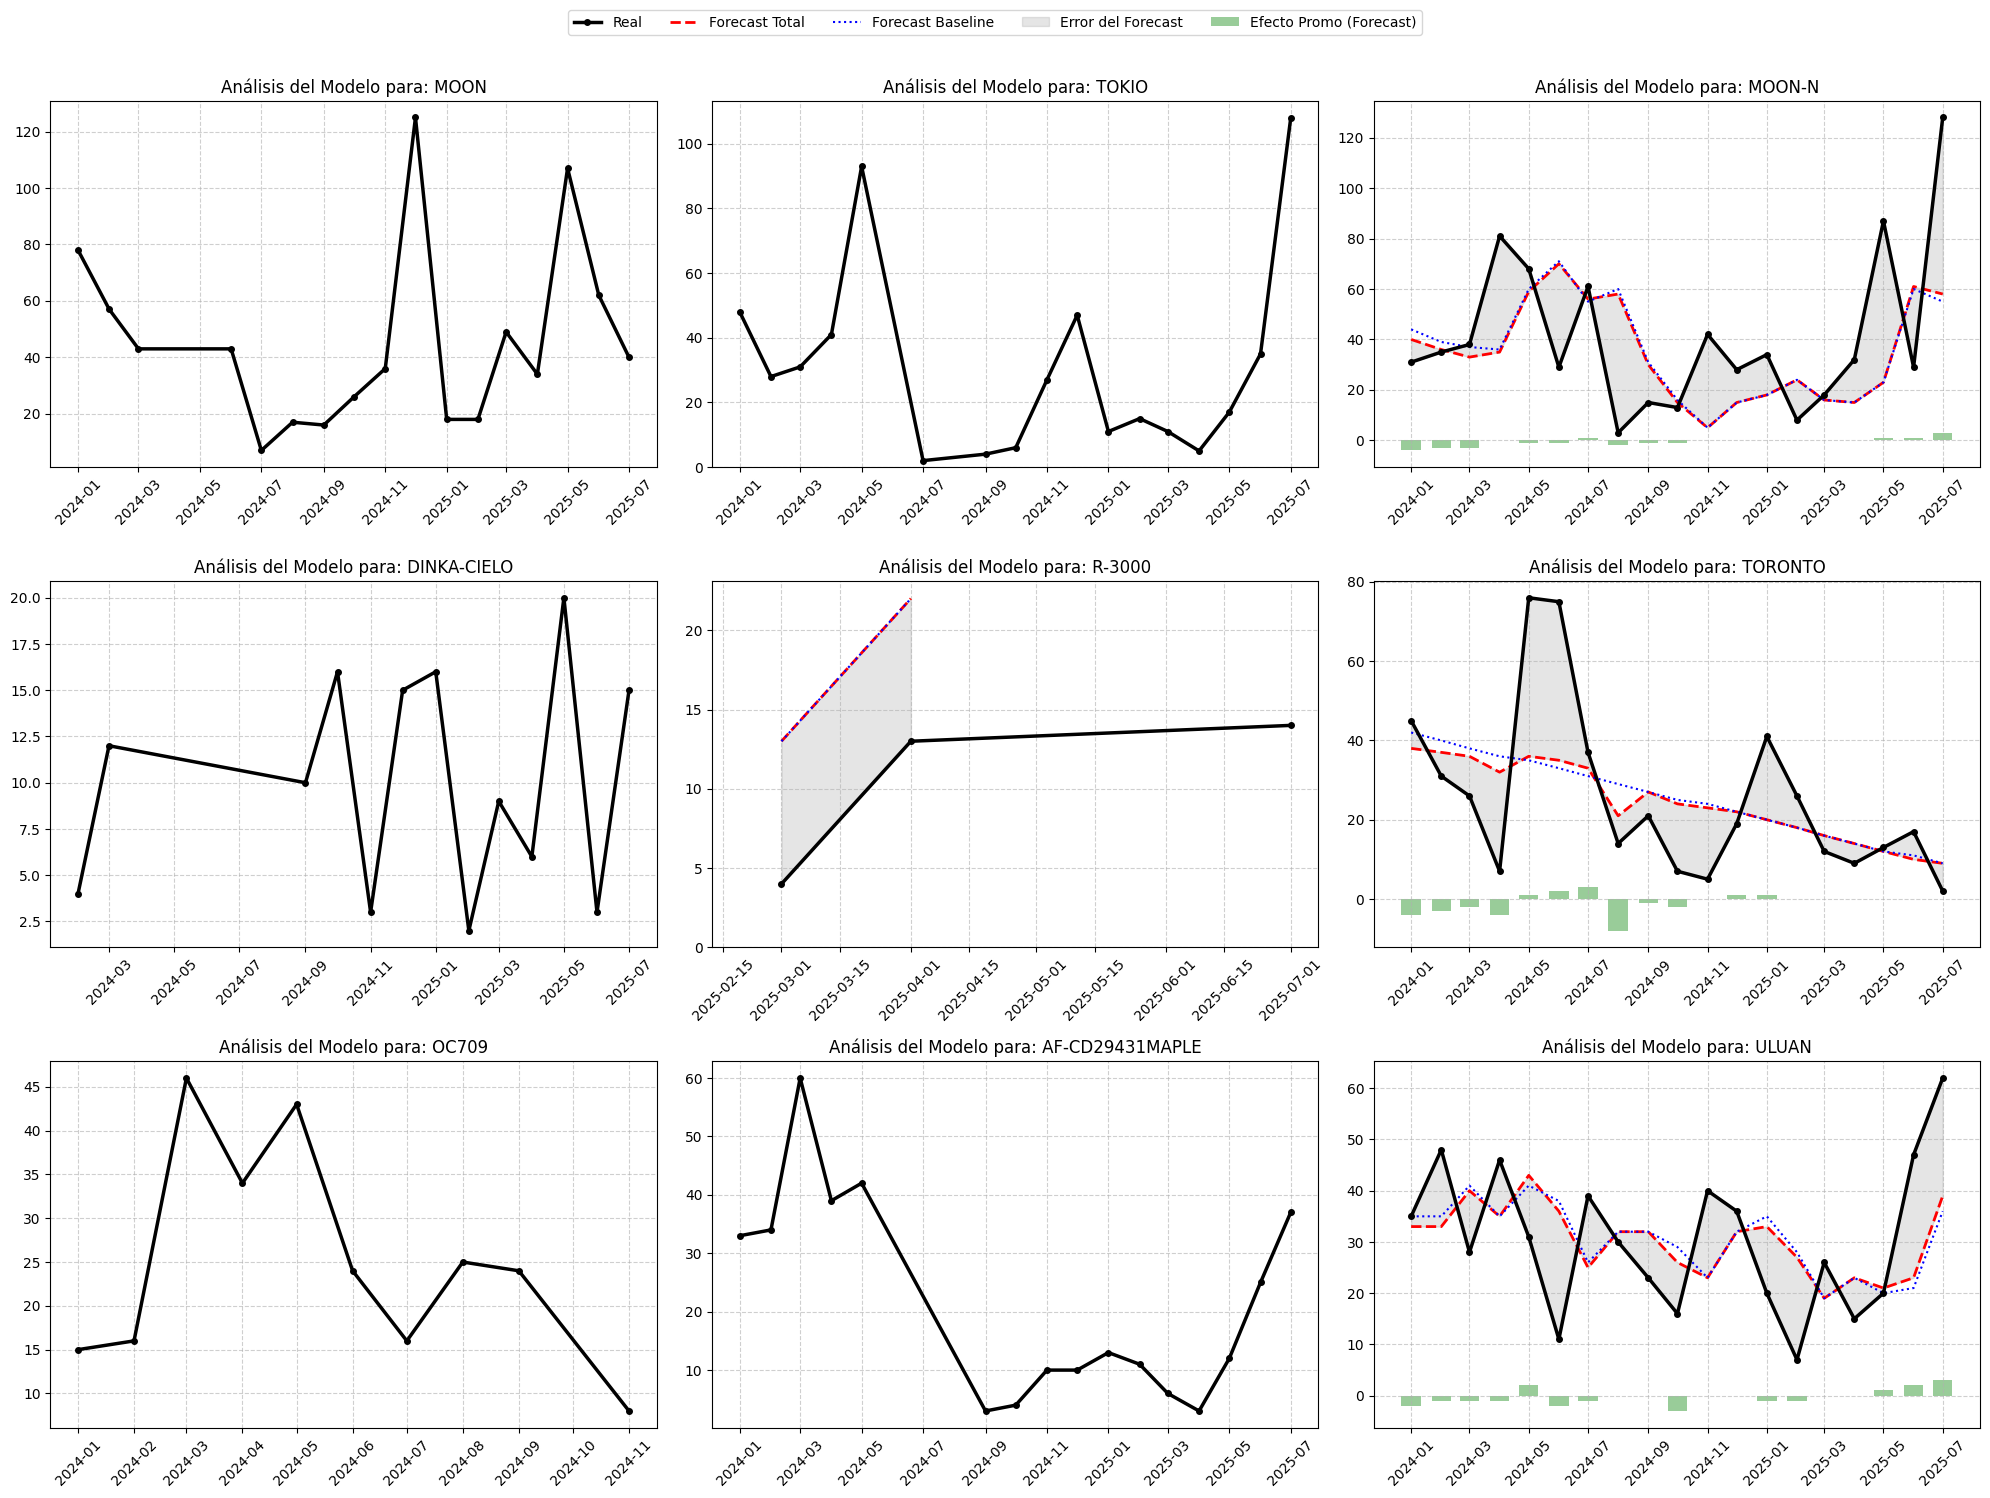

In [52]:
# Celda 4: Análisis Completo del Segmento B con Gráficos 3x3

print("--- ANÁLISIS DE SEGMENTO B (Simulación desde Dic-2024) ---")
skus_segmento_B = df_segmentation[df_segmentation['ABC_SEG'] == 'B']['SKU_ID'].tolist()
print(f"Analizando los {len(skus_segmento_B)} SKUs del Segmento B...")

forecast_origin_date = pd.to_datetime('2024-12-31')
results_list = []

for sku_id in tqdm(skus_segmento_B, desc="Generando forecasts para Segmento B"):
    train_data = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] <= forecast_origin_date)]
    if len(train_data) < 2: continue

    # --- OBTENER DATOS REALES Y PARÁMETROS ---
    date_m1 = pd.to_datetime('2025-01-01'); date_m4 = pd.to_datetime('2025-04-01')
    real_m1_row = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] == date_m1)]
    real_m4_row = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] == date_m4)]
    if real_m1_row.empty or real_m4_row.empty: continue

    asp_real_m1 = real_m1_row['ASP'].iloc[0]; real_m1 = real_m1_row['SI_ADJ'].iloc[0]
    asp_real_m4 = real_m4_row['ASP'].iloc[0]; real_m4 = real_m4_row['SI_ADJ'].iloc[0]
    stable_elasticity = train_data['ELASTICITY_ADJ'].mean(); stable_asp_avg = train_data['ASP_AVG'].mean()

    # --- GENERAR FORECAST USANDO EL MODELO DEL SEGMENTO B ---
    forecast_df, _ = forecast_segment_B(train_data, forecast_horizon=4, future_prices=[asp_real_m1, 0, 0, asp_real_m4])

    forecast_m1 = forecast_df.iloc[0]; forecast_m4 = forecast_df.iloc[3]

    # --- CONSOLIDAR RESULTADOS ---
    results_list.append({'SKU_ID': sku_id, 'Horizonte': 'M+1', 'Real': real_m1,'Tendencia': forecast_m1['si_por_tendencia'],'Efecto Promo': forecast_m1['si_ajuste_precios'],'Forecast Total': forecast_m1['si_por_tendencia'] + forecast_m1['si_ajuste_precios'],'ASP Real (Usado)': asp_real_m1, 'ASP Avg': stable_asp_avg,'% Dif ASP vs AVG': (asp_real_m1 / stable_asp_avg - 1) * 100 if stable_asp_avg > 0 else 0,'Elasticidad': stable_elasticity})
    results_list.append({'SKU_ID': sku_id, 'Horizonte': 'M+4', 'Real': real_m4,'Tendencia': forecast_m4['si_por_tendencia'],'Efecto Promo': forecast_m4['si_ajuste_precios'],'Forecast Total': forecast_m4['si_por_tendencia'] + forecast_m4['si_ajuste_precios'],'ASP Real (Usado)': asp_real_m4, 'ASP Avg': stable_asp_avg,'% Dif ASP vs AVG': (asp_real_m4 / stable_asp_avg - 1) * 100 if stable_asp_avg > 0 else 0,'Elasticidad': stable_elasticity})

if results_list:
    results_df = pd.DataFrame(results_list); results_df['Diferencia Abs.'] = abs(results_df['Real'] - results_df['Forecast Total']); results_df['APE (%)'] = results_df['Diferencia Abs.'] / results_df['Real'] * 100; results_df.replace([np.inf, -np.inf], 0, inplace=True)
    m1_df = results_df[results_df['Horizonte'] == 'M+1'].set_index('SKU_ID').drop(columns='Horizonte'); m4_df = results_df[results_df['Horizonte'] == 'M+4'].set_index('SKU_ID').drop(columns='Horizonte')
    print("\n" + "="*70 + "\n--- ANÁLISIS DE RESULTADOS M+1 (ENERO 2025) ---\n" + "="*70); print(m1_df.round(2))
    print("\n" + "="*70 + "\n--- ANÁLISIS DE RESULTADOS M+4 (ABRIL 2025) ---\n" + "="*70); print(m4_df.round(2))
    wape_m1 = (m1_df['Diferencia Abs.'].sum() / m1_df['Real'].sum()) * 100; mape_m1 = m1_df['APE (%)'].mean()
    wape_m4 = (m4_df['Diferencia Abs.'].sum() / m4_df['Real'].sum()) * 100; mape_m4 = m4_df['APE (%)'].mean()
    print("\n--- MÉTRICAS CONSOLIDADAS DEL SEGMENTO B ---"); print(f"Accuracy Ponderado M+1: {100-wape_m1:.2f}% | MAPE M+1: {mape_m1:.2f}%"); print(f"Accuracy Ponderado M+4: {100-wape_m4:.2f}% | MAPE M+4: {mape_m4:.2f}%")

    # --- GRÁFICOS TOP 9 SKUs ---
    print("\n" + "="*50 + "\n--- ANÁLISIS GRÁFICO DE TOP 9 SKUs (Segmento B) ---\n" + "="*50)
    top_9_skus = df_segmentation[df_segmentation['ABC_SEG'] == 'B']['SKU_ID'].head(9).tolist()
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    for i, sku in enumerate(top_9_skus):
        ax = axes[i]
        full_history = df_demand[df_demand['SKU_ID'] == sku]
        if full_history.empty:
            ax.text(0.5, 0.5, f'{sku}\n(Sin Datos)', ha='center', va='center'); ax.set_xticks([]); ax.set_yticks([]); continue
        _, fitted_model_df = forecast_segment_B(full_history, forecast_horizon=1)
        plot_df = full_history.set_index('PERIOD')[['SI_ADJ', 'SI_BASELINE']]
        plot_df = plot_df.join(fitted_model_df.rename(columns={'forecast_total': 'Forecast Total (Ajustado)'}))
        ax.plot(plot_df.index, plot_df['SI_ADJ'], label='Real', color='black', linewidth=2.5, marker='o', markersize=4, zorder=10)
        ax.plot(plot_df.index, plot_df['Forecast Total (Ajustado)'], label='Forecast Total', color='red', linestyle='--', linewidth=2)
        ax.plot(plot_df.index, plot_df['si_por_tendencia'], label='Forecast Baseline', color='blue', linestyle=':')
        ax.bar(plot_df.index, plot_df['si_ajuste_precios'], label='Efecto Promo (Forecast)', color='green', alpha=0.4, width=20)
        ax.fill_between(plot_df.index, plot_df['SI_ADJ'], plot_df['Forecast Total (Ajustado)'], color='grey', alpha=0.2, label='Error del Forecast')
        ax.set_title(f'Análisis del Modelo para: {sku}', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6); ax.tick_params(axis='x', rotation=45)
    fig.tight_layout(rect=[0, 0, 1, 0.96]); handles, labels = ax.get_legend_handles_labels(); by_label = dict(zip(labels, handles)); fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.0)); plt.show()
else:
    print("\nNo se pudieron generar resultados para el Segmento B.")

--- ANÁLISIS DE SEGMENTO C (Simulación desde Dic-2024) ---
Analizando los 152 SKUs del Segmento C...


Generando forecasts para Segmento C:   0%|          | 0/152 [00:00<?, ?it/s]


--- ANÁLISIS DE RESULTADOS M+1 (ENERO 2025) ---
               Real  Tendencia  Efecto Promo  Forecast Total  ASP Real (Usado)  ASP Avg  % Dif ASP vs AVG  Elasticidad  Diferencia Abs.  APE (%)
SKU_ID                                                                                                                                          
BOLONIA-BLACK    10        8.0           0.0             8.0            1699.0   1630.0              4.23         0.68              2.0    20.00
OBSIDIAN          5        5.0           0.0             5.0            1619.0   1452.0             11.50        -0.29              0.0     0.00
TRANSMUTARA       4       13.0           0.0            13.0            1699.0   1697.0              0.12         0.00              9.0   225.00
SURAT             7       11.0           0.0            11.0            1299.0   1381.0             -5.94         0.01              4.0    57.14
KIOTO             5        3.0           0.0             3.0            1259.0   

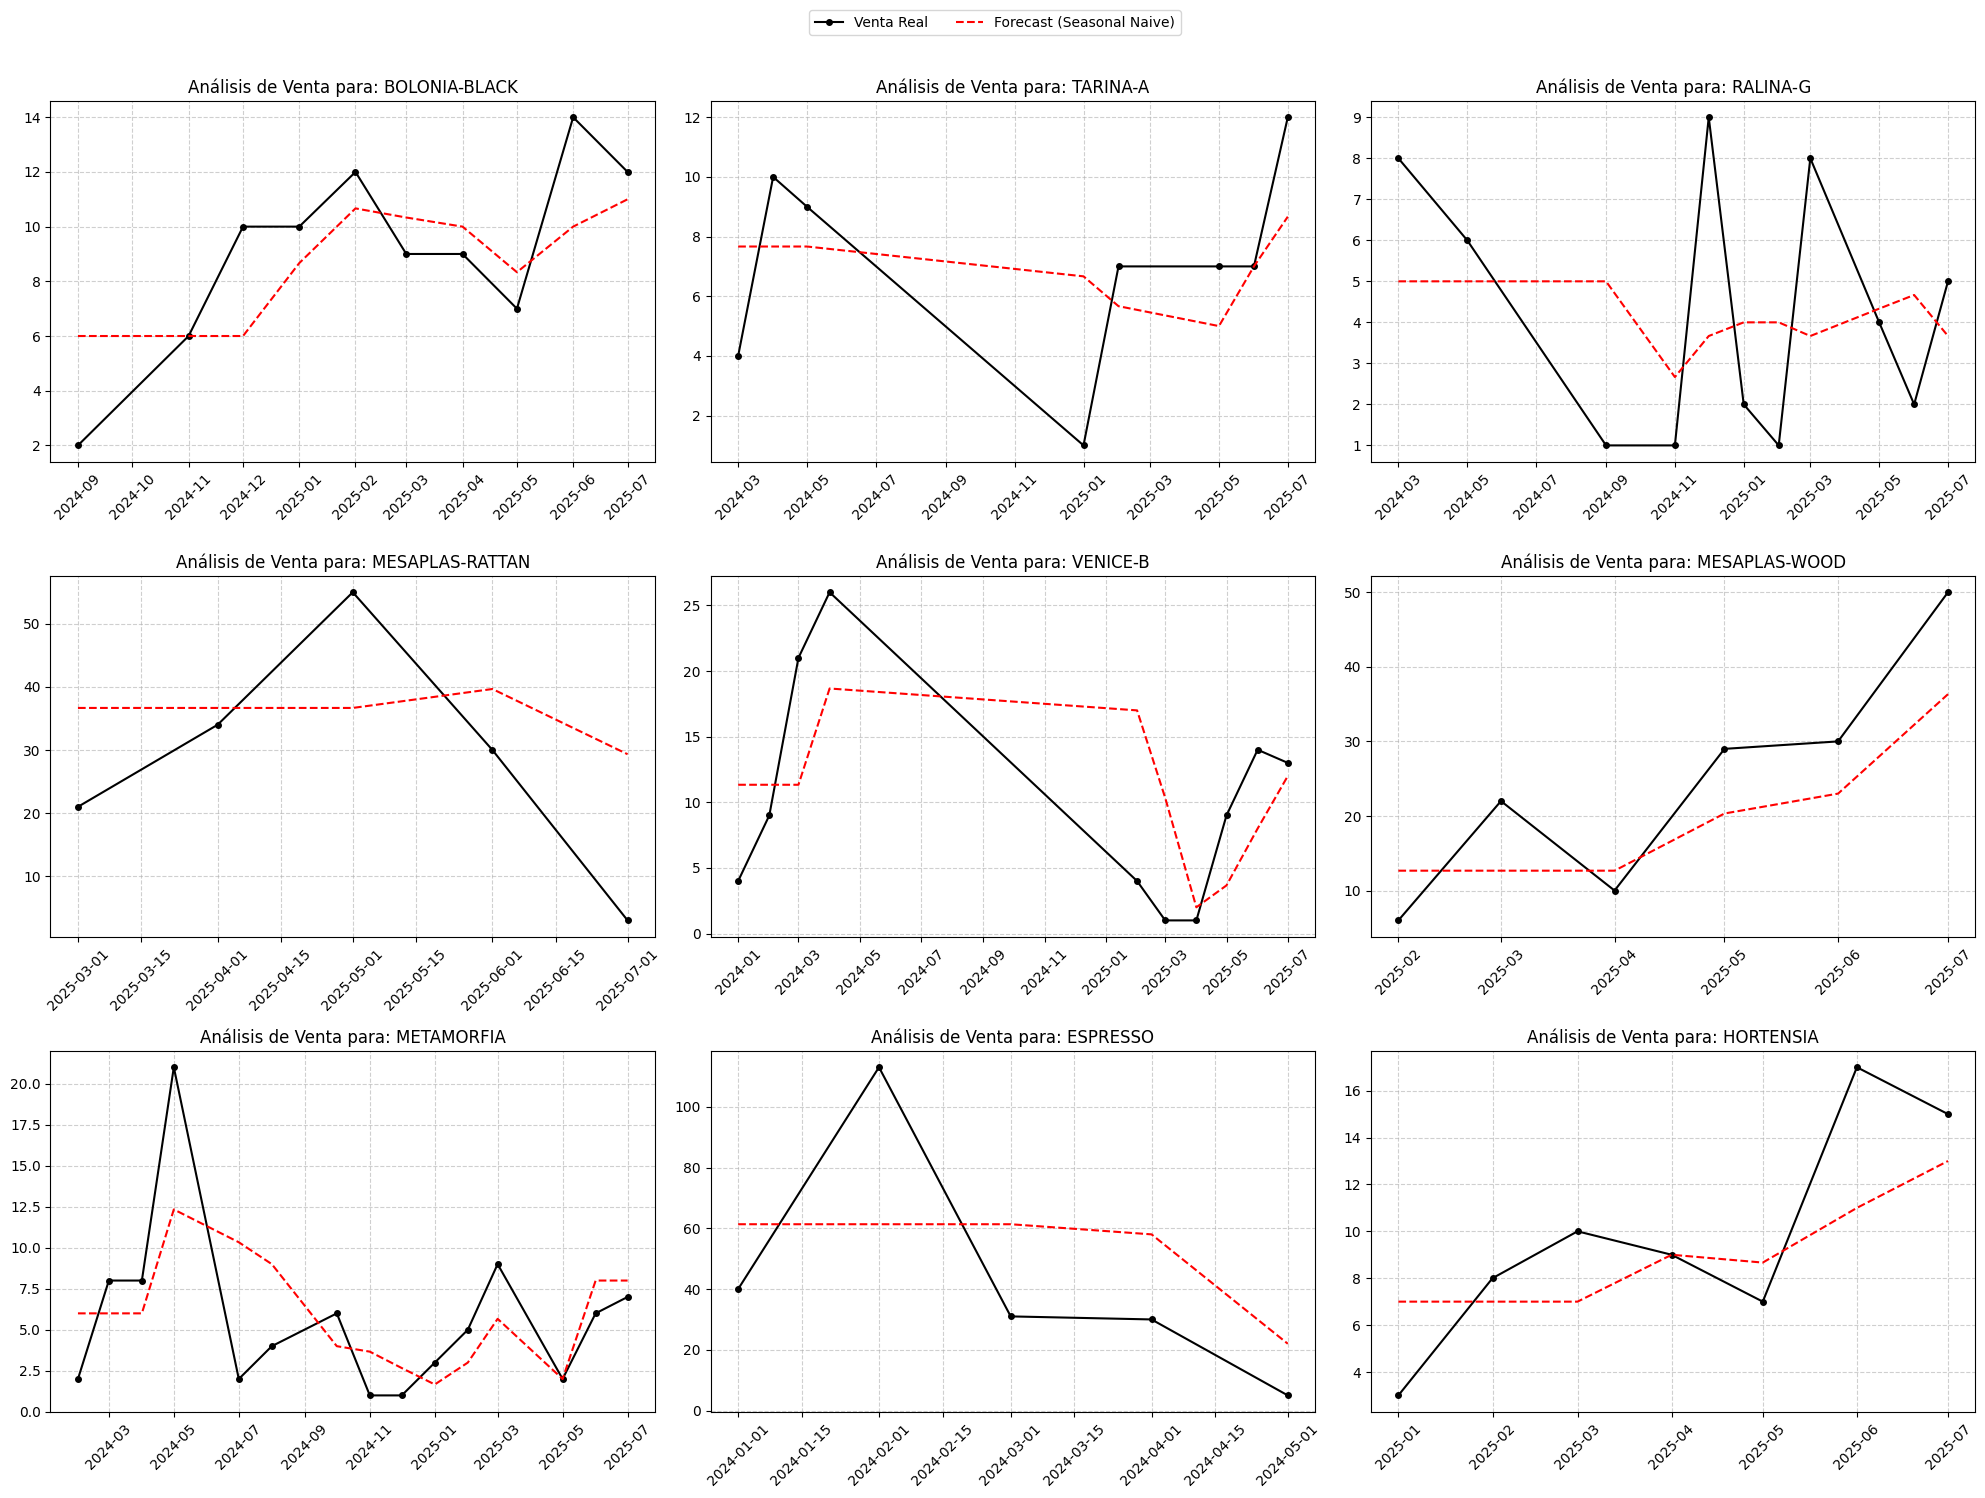

In [53]:
# Celda 5: Análisis Completo del Segmento C con Gráficos 3x3

print("--- ANÁLISIS DE SEGMENTO C (Simulación desde Dic-2024) ---")
skus_segmento_C = df_segmentation[df_segmentation['ABC_SEG'] == 'C']['SKU_ID'].tolist()
print(f"Analizando los {len(skus_segmento_C)} SKUs del Segmento C...")

forecast_origin_date = pd.to_datetime('2024-12-31')
results_list = []

for sku_id in tqdm(skus_segmento_C, desc="Generando forecasts para Segmento C"):
    train_data = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] <= forecast_origin_date)]
    if len(train_data) < 1: continue # El modelo C necesita menos historia
    date_m1 = pd.to_datetime('2025-01-01'); date_m4 = pd.to_datetime('2025-04-01')
    real_m1_row = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] == date_m1)]
    real_m4_row = df_demand[(df_demand['SKU_ID'] == sku_id) & (df_demand['PERIOD'] == date_m4)]
    if real_m1_row.empty or real_m4_row.empty: continue
    asp_real_m1 = real_m1_row['ASP'].iloc[0]; real_m1 = real_m1_row['SI_ADJ'].iloc[0]
    asp_real_m4 = real_m4_row['ASP'].iloc[0]; real_m4 = real_m4_row['SI_ADJ'].iloc[0]
    stable_elasticity = train_data['ELASTICITY_ADJ'].mean(); stable_asp_avg = train_data['ASP_AVG'].mean()

    # --- GENERAR FORECAST USANDO EL MODELO DEL SEGMENTO C ---
    forecast_df, _ = forecast_segment_C(train_data, forecast_horizon=4)

    forecast_m1 = forecast_df.iloc[0]; forecast_m4 = forecast_df.iloc[3]
    results_list.append({'SKU_ID': sku_id, 'Horizonte': 'M+1', 'Real': real_m1,'Tendencia': forecast_m1['si_por_tendencia'],'Efecto Promo': forecast_m1['si_ajuste_precios'],'Forecast Total': forecast_m1['forecast_total'],'ASP Real (Usado)': asp_real_m1, 'ASP Avg': stable_asp_avg,'% Dif ASP vs AVG': (asp_real_m1 / stable_asp_avg - 1) * 100 if stable_asp_avg > 0 else 0,'Elasticidad': stable_elasticity})
    results_list.append({'SKU_ID': sku_id, 'Horizonte': 'M+4', 'Real': real_m4,'Tendencia': forecast_m4['si_por_tendencia'],'Efecto Promo': forecast_m4['si_ajuste_precios'],'Forecast Total': forecast_m4['forecast_total'],'ASP Real (Usado)': asp_real_m4, 'ASP Avg': stable_asp_avg,'% Dif ASP vs AVG': (asp_real_m4 / stable_asp_avg - 1) * 100 if stable_asp_avg > 0 else 0,'Elasticidad': stable_elasticity})

if results_list:
    results_df = pd.DataFrame(results_list); results_df['Diferencia Abs.'] = abs(results_df['Real'] - results_df['Forecast Total']); results_df['APE (%)'] = results_df['Diferencia Abs.'] / results_df['Real'] * 100; results_df.replace([np.inf, -np.inf], 0, inplace=True)
    m1_df = results_df[results_df['Horizonte'] == 'M+1'].set_index('SKU_ID').drop(columns='Horizonte'); m4_df = results_df[results_df['Horizonte'] == 'M+4'].set_index('SKU_ID').drop(columns='Horizonte')
    print("\n" + "="*70 + "\n--- ANÁLISIS DE RESULTADOS M+1 (ENERO 2025) ---\n" + "="*70); print(m1_df.round(2))
    print("\n" + "="*70 + "\n--- ANÁLISIS DE RESULTADOS M+4 (ABRIL 2025) ---\n" + "="*70); print(m4_df.round(2))
    wape_m1 = (m1_df['Diferencia Abs.'].sum() / m1_df['Real'].sum()) * 100; mape_m1 = m1_df['APE (%)'].mean()
    wape_m4 = (m4_df['Diferencia Abs.'].sum() / m4_df['Real'].sum()) * 100; mape_m4 = m4_df['APE (%)'].mean()
    print("\n--- MÉTRICAS CONSOLIDADAS DEL SEGMENTO C ---"); print(f"Accuracy Ponderado M+1: {100-wape_m1:.2f}% | MAPE M+1: {mape_m1:.2f}%"); print(f"Accuracy Ponderado M+4: {100-wape_m4:.2f}% | MAPE M+4: {mape_m4:.2f}%")

    # --- GRÁFICOS TOP 9 SKUs ---
    print("\n" + "="*50 + "\n--- ANÁLISIS GRÁFICO DE TOP 9 SKUs (Segmento C) ---\n" + "="*50)
    top_9_skus = df_segmentation[df_segmentation['ABC_SEG'] == 'C']['SKU_ID'].head(9).tolist()
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()
    for i, sku in enumerate(top_9_skus):
        ax = axes[i]
        full_history = df_demand[df_demand['SKU_ID'] == sku]
        if full_history.empty:
            ax.text(0.5, 0.5, f'{sku}\n(Sin Datos)', ha='center', va='center'); ax.set_xticks([]); ax.set_yticks([]); continue

        # Para el Seg C, el modelo no tiene un 'fitted_values' complejo, por lo que graficamos el real vs el forecast simple
        ax.plot(full_history['PERIOD'], full_history['SI_ADJ'], label='Venta Real', color='black', marker='o', markersize=4)

        # Creamos un forecast histórico simple para comparar
        historic_forecast = full_history['SI_ADJ'].shift(12).fillna(full_history['SI_ADJ'].rolling(3).mean()).fillna(method='bfill')
        ax.plot(full_history['PERIOD'], historic_forecast, label='Forecast (Seasonal Naive)', color='red', linestyle='--')

        ax.set_title(f'Análisis de Venta para: {sku}', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6); ax.tick_params(axis='x', rotation=45)
    fig.tight_layout(rect=[0, 0, 1, 0.96]); handles, labels = ax.get_legend_handles_labels(); by_label = dict(zip(labels, handles)); fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.0)); plt.show()
else:
    print("\nNo se pudieron generar resultados para el Segmento C.")

In [61]:
# Celda 6 (Definitiva): Forecast Agregado por Segmento (Ene/25 - Ago/26)

print("--- GENERANDO FORECAST COMPLETO PARA TODOS LOS SKUs (24 MESES) ---")
last_date_in_data = df_demand['PERIOD'].max()
train_df_full = df_demand[df_demand['PERIOD'] <= last_date_in_data]
full_forecast_list = []

for sku_id in tqdm(df_segmentation['SKU_ID'].unique(), desc="Generando forecast SKU por SKU"):
    sku_history = train_df_full[train_df_full['SKU_ID'] == sku_id]
    if sku_history.empty: continue
    segment = df_segmentation[df_segmentation['SKU_ID'] == sku_id]['ABC_SEG'].iloc[0]

    if segment == 'A':
        forecast_output, _ = forecast_segment_A(sku_history, forecast_horizon=24)
    elif segment == 'B':
        forecast_output, _ = forecast_segment_B(sku_history, forecast_horizon=24)
    else:
        forecast_output, _ = forecast_segment_C(sku_history, forecast_horizon=24)

    forecast_output['SKU_ID'] = sku_id
    full_forecast_list.append(forecast_output)

master_forecast_df = pd.concat(full_forecast_list).reset_index().rename(columns={'index': 'PERIOD'})
master_forecast_df['forecast_gmv'] = master_forecast_df['forecast_total'] * master_forecast_df['forecast_asp']
master_forecast_df = pd.merge(master_forecast_df, df_segmentation[['SKU_ID', 'ABC_SEG']], on='SKU_ID', how='left')

# --- PREPARAR DATOS HISTÓRICOS Y COMBINARLOS CON EL FORECAST ---

# --- INICIO DE LA CORRECCIÓN ---
# 1. Unimos los datos históricos con la segmentación ANTES de agrupar
df_demand_segmented = pd.merge(df_demand, df_segmentation[['SKU_ID', 'ABC_SEG']], on='SKU_ID', how='left')
# --- FIN DE LA CORRECCIÓN ---

# 2. Agregamos los datos históricos ya segmentados
df_demand_segmented['GMV_ADJ'] = df_demand_segmented['SI_ADJ'] * df_demand_segmented['ASP']
historic_agg_si = df_demand_segmented.groupby(['PERIOD', 'ABC_SEG'])['SI_ADJ'].sum().unstack().fillna(0)
historic_agg_gmv = df_demand_segmented.groupby(['PERIOD', 'ABC_SEG'])['GMV_ADJ'].sum().unstack().fillna(0)

# 3. Agregamos los datos del forecast
forecast_agg_si = master_forecast_df.groupby(['PERIOD', 'ABC_SEG'])['forecast_total'].sum().unstack().fillna(0)
forecast_agg_gmv = master_forecast_df.groupby(['PERIOD', 'ABC_SEG'])['forecast_gmv'].sum().unstack().fillna(0)

# 4. Combinamos Histórico + Forecast
full_view_si = pd.concat([historic_agg_si, forecast_agg_si])
full_view_gmv = pd.concat([historic_agg_gmv, forecast_agg_gmv])
# Eliminar posibles duplicados que puedan surgir de la concatenación
full_view_si = full_view_si[~full_view_si.index.duplicated(keep='last')]
full_view_gmv = full_view_gmv[~full_view_gmv.index.duplicated(keep='last')]


# 5. Filtramos por el rango de fechas solicitado
start_date = '2025-01-01'
end_date = '2026-08-01'
final_si_table = full_view_si[(full_view_si.index >= start_date) & (full_view_si.index <= end_date)]
final_gmv_table = full_view_gmv[(full_view_gmv.index >= start_date) & (full_view_gmv.index <= end_date)]

# --- PRESENTACIÓN DE RESULTADOS POR SEGMENTO ---
print("\n" + "="*70 + f"\n--- VISTA CONSOLIDADA DE UNIDADES (SI) POR SEGMENTO ({start_date} a {end_date}) ---\n" + "="*70)
print(final_si_table.astype(int))

print("\n" + "="*70 + f"\n--- VISTA CONSOLIDADA DE INGRESOS (GMV) POR SEGMENTO ({start_date} a {end_date}) ---\n" + "="*70)
print(final_gmv_table.applymap('{:,.0f}'.format))

--- GENERANDO FORECAST COMPLETO PARA TODOS LOS SKUs (24 MESES) ---


Generando forecast SKU por SKU:   0%|          | 0/267 [00:00<?, ?it/s]


--- VISTA CONSOLIDADA DE UNIDADES (SI) POR SEGMENTO (2025-01-01 a 2026-08-01) ---
ABC_SEG        A     B     C
PERIOD                      
2025-01-01   114   128  1940
2025-02-01   140   168  2220
2025-03-01   150   195  2334
2025-04-01   168   291  2350
2025-05-01   171   405  2757
2025-06-01    76   388  1720
2025-07-01   216   513  2227
2025-08-01  4123  1110  2564
2025-09-01  4124  1173  2620
2025-10-01  3941  1223  2579
2025-11-01  4576  1329  2598
2025-12-01  4579  1414  2605
2026-01-01  4611  1467  2609
2026-02-01  4689  1548  2194
2026-03-01  4848  1644  1658
2026-04-01  5220  1724  1489
2026-05-01  5565  1857  1545
2026-06-01  5590  1923  1528
2026-07-01  5699  1937  1061
2026-08-01  5815  1728   605

--- VISTA CONSOLIDADA DE INGRESOS (GMV) POR SEGMENTO (2025-01-01 a 2026-08-01) ---
ABC_SEG             A          B          C
PERIOD                                     
2025-01-01    186,960    308,736    836,975
2025-02-01    194,600    387,835    990,273
2025-03-01    199,5

In [62]:
# Celda 7: Forecast Agregado a Nivel Negocio Total

print("--- CONSOLIDANDO FORECAST A NIVEL NEGOCIO TOTAL ---")

# Usamos la tabla maestra generada en la celda anterior
total_business_forecast = master_forecast_df.groupby('PERIOD')[['forecast_total', 'forecast_gmv']].sum()
total_business_forecast.rename(columns={'forecast_total': 'Total Unidades (SI)', 'forecast_gmv': 'Total Ingresos (GMV)'}, inplace=True)

print("\n" + "="*50 + "\n--- FORECAST TOTAL NEGOCIO (12 MESES) ---\n" + "="*50)

# Formatear la salida para que sea fácil de leer
total_business_forecast['Total Ingresos (GMV)'] = total_business_forecast['Total Ingresos (GMV)'].map('{:,.0f}'.format)
total_business_forecast['Total Unidades (SI)'] = total_business_forecast['Total Unidades (SI)'].map('{:,.0f}'.format)

print(total_business_forecast.head(12))

--- CONSOLIDANDO FORECAST A NIVEL NEGOCIO TOTAL ---

--- FORECAST TOTAL NEGOCIO (12 MESES) ---
           Total Unidades (SI) Total Ingresos (GMV)
PERIOD                                             
2024-02-01                 364               64,970
2024-03-01                 871              270,423
2024-04-01                 990              414,796
2024-05-01               1,016              421,752
2024-06-01               1,159              492,535
2024-07-01               1,645              635,716
2024-08-01               2,145              915,848
2024-09-01               2,228              989,597
2024-10-01               2,238            1,009,100
2024-11-01               2,278            1,083,113
2024-12-01               2,352            1,276,941
2025-01-01               2,182            1,332,671
